
# Анализ пользовательского поведения в мобильном приложении

Проект выполнен для стартапа, который продает продукты питания. 

Цель: изучить поведение пользователей мобильного приложения.

Входные данные: записи в логах (действие пользователя, или событие) приложения.

План работы:
1. Сделать обзор данных, провести предобработку
2. Проверить данные
3. Изучить воронку событий
4. Проанализировать результаты эксперимента
5. Сделать вывод

## Обзор данных, предобработка

In [ ]:
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy.stats as stats
import math as mth

In [ ]:
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
logs.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [ ]:
logs = logs.rename(columns={'EventName': 'name', 
                            'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'timestamp', 
                            'ExpId': 'exp_id'})

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   name       244126 non-null  object
 1   user_id    244126 non-null  int64 
 2   timestamp  244126 non-null  int64 
 3   exp_id     244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
# Добавление стобцов с датой и временем и отдельно с датой
logs['datetime'] = pd.to_datetime(logs['timestamp'], unit="s")
logs['date'] = logs['datetime'].dt.date

In [ ]:
logs.head()

,name,user_id,timestamp,exp_id,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


In [ ]:
logs.isna().sum()

name         0
user_id      0
timestamp    0
exp_id       0
datetime     0
date         0
dtype: int64

In [ ]:
logs.duplicated().sum()

413

In [ ]:
logs = logs.drop_duplicates().reset_index()
logs.duplicated().sum()

0

В данных не было пропусков, но были обнаружены явные дубликаты. Дубликаты лучше удалить, чтобы не исказить результаты исследования.

In [ ]:
uni = logs.groupby('user_id').nunique('exp_id').sort_values(by = 'exp_id', ascending = False)
uni['exp_id']

user_id
6888746892508752       1
6207768971558512760    1
6217807653094995999    1
6217295124800833842    1
6216080220799726690    1
                      ..
3175239243679501019    1
3171891164497446149    1
3171454373076660766    1
3170212200647575044    1
9222603179720523844    1
Name: exp_id, Length: 7551, dtype: int64

В данных нет одинаковых пользователей, которые попали в разные группы.

## Проверка данных

In [ ]:
# изучение данных
event_count = logs['name'].count()
user_count = logs['user_id'].nunique()
print('Количество всех событий в логах:', event_count)
print('Количество пользователей:', user_count)
print('Среднее количество событий на пользователя:', round(event_count/user_count))

Количество всех событий в логах: 243713
Количество пользователей: 7551
Среднее количество событий на пользователя: 32


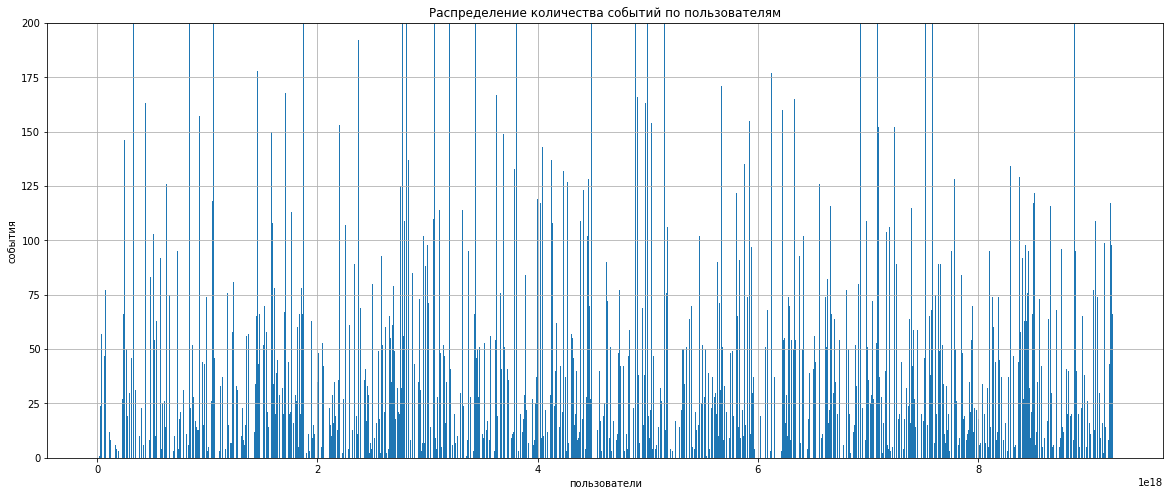

In [ ]:
plt.figure(figsize=(20, 8))
logs['user_id'].hist(bins = 7551)

plt.title('Распределение количества событий по пользователям')
plt.ylabel('события')
plt.xlabel('пользователи')
plt.ylim (0, 200)
plt.show()

In [ ]:
# период данных
print('Минимальная дата:', logs['date'].min())
print('Максимальная дата:', logs['date'].max())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


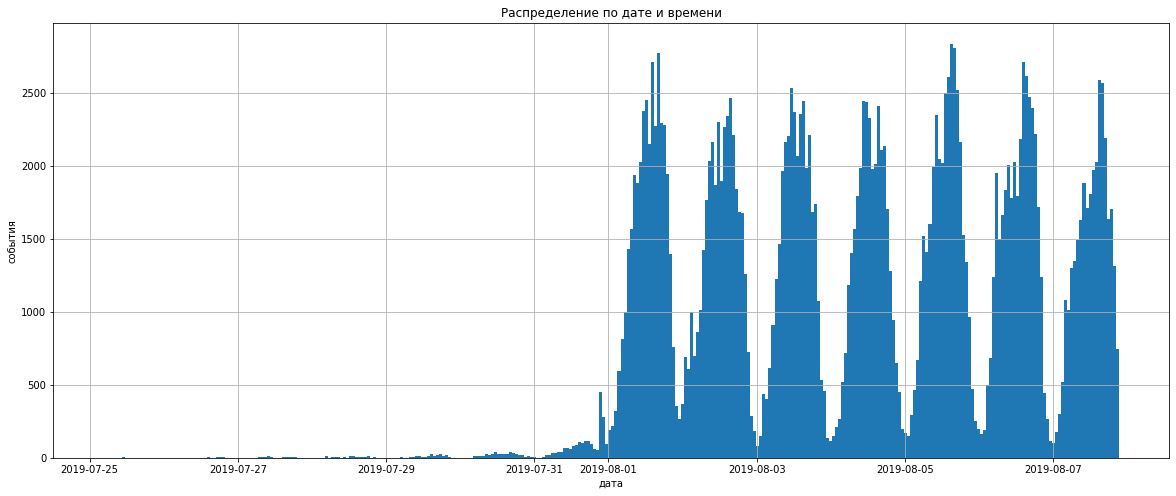

In [ ]:
plt.figure(figsize=(20, 8))
logs['datetime'].hist(bins = 14*24)

plt.title('Распределение по дате и времени')
plt.ylabel('события')
plt.xlabel('дата')

plt.show()

Данные неполные за весь период. До 01-08-2019 данных было мало, они могут добавляться из прошлого, «доезжать» позднее, и это может исказить дальнейшие результаты. По этой причине лучше отбросить старые данные.
Актуальный период исследования: 01-08-2019 - 07-08-2019

In [ ]:
# срез с данными за актуальный период
startdate =  pd.to_datetime('2019-08-01').date()
logs_actual = logs.loc[logs['date'] >= startdate]
logs_actual

,index,name,user_id,timestamp,exp_id,datetime,date
2826,2828,Tutorial,3737462046622621720,1564618048,246,2019-08-01 00:07:28,2019-08-01
2827,2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2828,2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2829,2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2830,2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
...,...,...,...,...,...,...,...
243708,244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-07
243709,244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-07
243710,244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-07
243711,244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-07


In [ ]:
# потерянные данные
logs_lost = logs.loc[logs['date'] < startdate]
print('Абсолютное количество потерянных событий:', len(logs_lost))
print('Относительное количество потерянных событий: {}%'.format(round(len(logs_lost)/event_count*100, 2)))

Абсолютное количество потерянных событий: 2826
Относительное количество потерянных событий: 1.16%


In [ ]:
users_lost = logs['user_id'].nunique() - logs_actual['user_id'].nunique()
print('Абсолютное количество потерянных пользователей:', users_lost)
print('Относительное количество потерянных пользователей: {}%'.format(round(users_lost/user_count*100, 2)))


Абсолютное количество потерянных пользователей: 17
Относительное количество потерянных пользователей: 0.23%


После отброса старых данных было потеряно 2826 событий и 17 пользователь.

In [ ]:
logs_actual['exp_id'].value_counts()

248    84563
246    79302
247    77022
Name: exp_id, dtype: int64

Во всех экспериментальных группах есть пользователи.

## Изучение воронки событий

In [ ]:
# Частота событий, встречающихся в логах
events = logs_actual['name'].value_counts().to_frame().reset_index()
events.columns = ['name', 'frequency']
events['per'] = round((events['frequency']/logs_actual['name'].count() * 100), 1)
events

,name,frequency,per
0,MainScreenAppear,117328,48.7
1,OffersScreenAppear,46333,19.2
2,CartScreenAppear,42303,17.6
3,PaymentScreenSuccessful,33918,14.1
4,Tutorial,1005,0.4


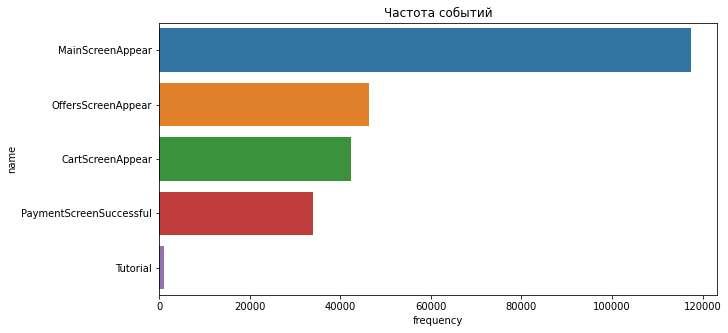

In [ ]:
plt.figure(figsize=(10, 5)) 
plt.title('Частота событий')
sns.barplot(data=events, x='frequency', y = 'name')
plt.show()

Самым частым событием является MainScreenAppear - появление главного экрана, запуск приложения. Самым редким - Tutorial. Не все проходят обучение по пользованию приложением. Неизвестно, в какой момент пользователям предлагается пройти обучение, поэтому дальнейший анализ можно проводить без этого события - этот этап необязательный.

In [ ]:
logs_actual = logs_actual.query('name != "Tutorial"')

In [ ]:
# Количество пользователей, совершавших каждое событие
events_users = (
    logs_actual.groupby('name')
    .agg({'user_id': 'nunique'})
    .sort_values(by = 'user_id', ascending = False)
)
events_users.columns = ['users_amount']

# Доля пользователей, которые хоть раз совершали событие
events_users['per'] = round((events_users['users_amount']/logs_actual['user_id'].nunique() * 100), 1)
events_users

,users_amount,per
name,,
MainScreenAppear,7419,98.5
OffersScreenAppear,4593,61.0
CartScreenAppear,3734,49.6
PaymentScreenSuccessful,3539,47.0


In [ ]:
# Доля пользователей, переходящих на следующий шаг воронки (для первого события )
events_users['part'] = 100
for i in range(1,len(events_users['users_amount'])):
    events_users['part'].iloc[i] = round((events_users['users_amount'][i] / events_users['users_amount'][i-1]*100), 1)

pd.options.mode.chained_assignment = None #убирает предупреждение цепного значения
events_users

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,users_amount,per,part
name,,,
MainScreenAppear,7419,98.5,100.0
OffersScreenAppear,4593,61.0,61.9
CartScreenAppear,3734,49.6,81.3
PaymentScreenSuccessful,3539,47.0,94.8


1. На первое событие попало 98,5%. Значит, что небольшая часть пользователей не запустила приложение. Возможно, есть проблемы с запуском, либо пользователи могли перейти из поисковой строки, рассылки и т.д.
2. На второе событие попал 61% пользователей. Здесь происходит самая большая потеря пользователей - 38,1%.
3. На третье событие попадает 49,6% пользователей и 47% успешно совершает оплату - последнее событие. На этих этапах потеря минимальная - 19% и 6%.

Таким образом, 47% пользователей доходит от первого события до оплаты.



## Изучение результатов эксперимента

In [ ]:
# количество пользователей в экспериментальных группах
group246 = (logs_actual.query('exp_id == 246')['user_id'].nunique())
group247 = (logs_actual.query('exp_id == 247')['user_id'].nunique())
group248 = (logs_actual.query('exp_id == 248')['user_id'].nunique())
print('Количество уникальных пользователей в 246 группе:', group246)
print('Количество уникальных пользователей в 247 группе:', group247)
print('Количество уникальных пользователей в 248 группе:', group248)

Количество уникальных пользователей в 246 группе: 2483
Количество уникальных пользователей в 247 группе: 2512
Количество уникальных пользователей в 248 группе: 2535


Количество пользователей примерно одинаково, поэтому можно считать группы сбалансированными.
246 и 247 — контрольные группы, а 248 — экспериментальная.

In [ ]:
# Функция для проверки гипотез
def test_hypo(success1, success2, trials1, trials2, alpha):
    
    alpha = alpha
   
    p1 = success1 / trials1
    p2 = success2 / trials2
    
    p = (success1 + success2) / (trials1 + trials2)
 
    difference = p1 - p2
    z_value = difference / mth.sqrt(p *(1-p) * (1/trials1 + 1/trials2))
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-значение: ', p_value)
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между группами есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными")

In [ ]:
# Сводная таблица с количеством пользователей в каждой группе по событиям
users_groups = (
    logs_actual
    .pivot_table(index='name', columns='exp_id', values='user_id', aggfunc = 'nunique')
    .sort_values(246, ascending=False)
)
users_groups

exp_id,246,247,248
name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181


Проведем A/A-тестирование для проверки корректности всех механизмов и расчётов. Уровень значимость выбран 0,05, потребуется 4 проверки статистических гипотез.

**Нулевая гипотеза**: доли уникальных посетителей, побывавших на этапе воронки, одинаковы.

**Альтенативная гипотеза**: между долями уникальных посетителей, побывавших на этапе воронки, есть значимая разница.

In [ ]:
# сравнение групп 246 и 247
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 246], users_groups.loc[name, 247], group246, group247, 0.05)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Между группами 246 и 247 нет разницы по каждому событию. Разбиение на группы работает корректно.

Проанализируем результаты A/B-теста с использованием тех же гипотез.

In [ ]:
# сравнение групп 246 и 248
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 246], users_groups.loc[name, 248], group246, group248, 0.05)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [ ]:
# сравнение групп 247 и 248
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 247], users_groups.loc[name, 248], group247, group248, 0.05)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Разницы между сравнением 246 и 248 групп и 247 и 248 групп нет. 

Объединим контрольные группы 246 и 247, после чего сравним с 248 группой.

In [ ]:
# Общее количество из групп 246 и 247
group246_247 = group246 + group247

# Добавление объединенной группы
users_groups['246+247'] = users_groups[[246,247]].sum(axis=1)
users_groups

exp_id,246,247,248,246+247
name,,,,
MainScreenAppear,2450,2476,2493,4926
OffersScreenAppear,1542,1520,1531,3062
CartScreenAppear,1266,1238,1230,2504
PaymentScreenSuccessful,1200,1158,1181,2358


In [ ]:
# сравнение объединенной и экспериментальной групп 
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, '246+247'], users_groups.loc[name, 248], group246_247, group248, 0.05)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



Разницы между сравнением объединенной и экспериментальной групп нет. 

При множественной проверке гипотез растет вероятность ошибки первого рода - растет вероятность получения ложноположительного результата. Воспользуемся поправкой Бонферрони, чтобы пересчитать уровень значимости. Для этого потребуется поделить изначальный уровень значимости на общее число тестов. В исследовании было проведено 4 А/A-теста и 12 A/B-тестов. 
Значит, всего было проведено 16 тестов:

In [ ]:
0.05/16

0.003125

Перепроверим результаты, используя новый уровень значимости - 0.003125.

In [ ]:
# сравнение групп 246 и 247
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 246], users_groups.loc[name, 247], group246, group247, 0.003125)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.7526703436483038
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.24786096925282264
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.22867643757335676
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.11446627829276612
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [ ]:
# сравнение групп 246 и 248
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 246], users_groups.loc[name, 248], group246, group248, 0.003125)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.3387114076159288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.21442476639710506
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.08067367598823139
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.21693033984516674
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [ ]:
# сравнение групп 247 и 248
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, 247], users_groups.loc[name, 248], group247, group248, 0.003125)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.5194964354051703
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.9333751305879443
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.5878284605111943
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.7275718682261119
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



In [ ]:
# сравнение объединенной и экспериментальной групп 
for name in users_groups.index:
    print('Проверка для события', name, ':')
    test_hypo(users_groups.loc[name, '246+247'], users_groups.loc[name, 248], group246_247, group248, 0.003125)
    print()

Проверка для события MainScreenAppear :
p-значение:  0.3486684291093256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события OffersScreenAppear :
p-значение:  0.44582745409482394
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события CartScreenAppear :
p-значение:  0.18683558686831558
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными

Проверка для события PaymentScreenSuccessful :
p-значение:  0.6107918742187335
Не получилось отвергнуть нулевую гипотезу, нет оснований считать группы разными



После поправки Бонферрони в сравнениях групп не оказалось разницы. Значит, изменения не влияют на пользователей.

## Вывод

Перед исследование были получены логи событий мобильного приложения. Период исследования: 01-08-2019 - 07-08-2019. 

После предобработки и изучения воронки событий сделаны выводы о том, что: 
1. В среднем на пользователя приходится 32 события. 
2. После удаления неактуальных данных было потеряно небольшое количество пользователей и событий.
3. Самым частым событием является MainScreenAppear - появление главного экрана, событие составило 48,9% от общего количества событий. 
4. Самое редкое событие - Tutorial. Событие составило 0,4% от общего количества событий. Этап необязательный, поэтому он был удален. 
5. Больше всего пользователей теряется на этапе OffersScreenAppear о предложении покупки, потеря составляет 37%. 
6. От первого события до последнего доходит 47% пользователей. Это хороший результат, но следует провести дополнительное исследование по причинам потери пользователей и повысить показатели.

После анализа результатов A/A-тестирования можно сделать вывод о том, что группы были разбиты корректно. 

A/B-тест показал, что изменение шрифтов во всем приложении никак не повлияли на пользователей, проблем не возникло. Значит, можно поменять шрифты, но это будет иметь нейтральный эффект - показатели воронки событий не изменятся.